* 특성 추가는 모델을 복잡하게 만들고 과대적합될 가능성을 높임
* 따라서 반대로 유용한 특성만 선택하면 모델이 간단해지고 일반화 성능이 높아짐

# 일변량 통계

* 특성별로 지정한 테스트 점수를 도출
    * 분류에서는 보통 f_classif
    * 회귀에서는 보통 f_regression<br><br>
* 임계값을 통해 높은 테스트 점수를 가진 특성을 선택
    * SelectKBest : 고정된 k개의 특성을 선택
    * SelectPercentile : 지정된 비율만큼 특성 선택

In [1]:
from ml1.preamble import*
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

# 의미없는 노이즈 특성 50개 추가
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data),50))
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target, random_state=0, test_size=.5)

select = SelectPercentile(score_func=f_classif, percentile=50)
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)

print(X_train.shape)
print(X_train_selected.shape)

(284, 80)
(284, 40)


=> 특성이 80개에서 40개로 줄어들음

* 선택된 특성

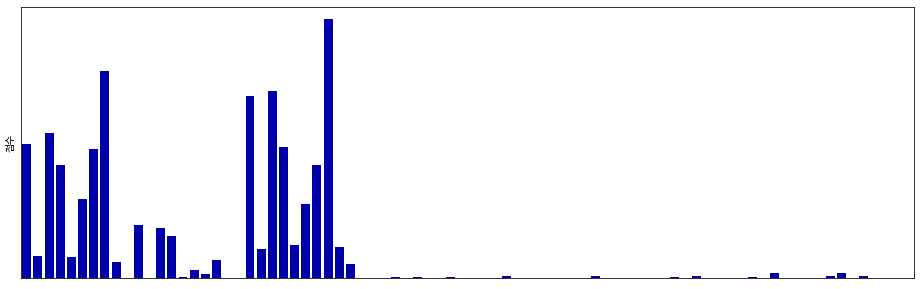

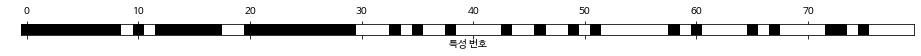

In [2]:
mask = select.get_support()

plt.figure(figsize=(16,5))
plt.bar(np.arange(len(select.scores_)), select.scores_)
plt.yticks([])
plt.xticks([])
plt.ylabel('점수')
plt.xlim(-0.5,79.5)

plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel('특성 번호')
plt.yticks([])
plt.ylabel(' ')
plt.show()

In [3]:
from sklearn.linear_model import LogisticRegression

X_test_selected = select.transform(X_test)

lr= LogisticRegression(max_iter=5000).fit(X_train, y_train)
print(f'전체 특성을 사용한 점수: {lr.score(X_test, y_test):.3f}')

lr =LogisticRegression(max_iter=5000).fit(X_train_selected, y_train)
print(f'선택된 특성을 사용한 점수: {lr.score(X_test_selected, y_test):.3f}')

전체 특성을 사용한 점수: 0.951
선택된 특성을 사용한 점수: 0.933


# 모델 기반 특성 선택

* 지도 학습 머신러닝 모델을 사용하여 특성의 중요도를 평가
    * 트리기반 모델의 feature_importances_
    * 선형모델의 계수의 절대값

In [4]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')

select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)

print(X_train.shape)
print(X_train_l1.shape)

(284, 80)
(284, 40)


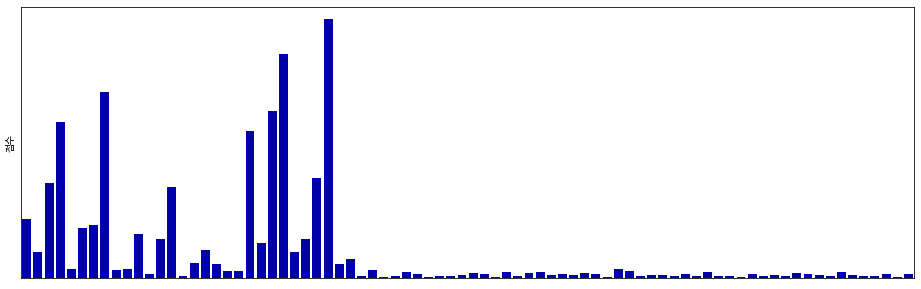

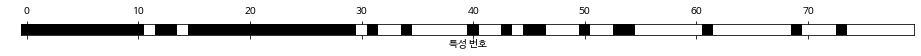

In [5]:
tree = select.estimator_
scores = tree.feature_importances_
mask = select.get_support()

plt.figure(figsize=(16,5))
plt.bar(np.arange(len(scores)), scores)
plt.yticks([])
plt.xticks([])
plt.ylabel('점수')
plt.xlim(-0.5,79.5)

plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel('특성 번호')
plt.yticks([])
plt.ylabel(' ')
plt.show()

In [6]:
X_test_l1 = select.transform(X_test)

lr= LogisticRegression(max_iter=5000).fit(X_train, y_train)
print(f'전체 특성을 사용한 점수: {lr.score(X_test, y_test):.3f}')

lr =LogisticRegression(max_iter=5000).fit(X_train_l1, y_train)
print(f'선택된 특성을 사용한 점수: {lr.score(X_test_l1, y_test):.3f}')

전체 특성을 사용한 점수: 0.951
선택된 특성을 사용한 점수: 0.947


# 반복적 특성 선택

1. 모든 특성으로 시작해서 모델 생성
2. 특성 중요도(coef_/ feature_importances)가 가장 낮은 특성 제거
3. 나머지 특성들로 새로운 모델 생성
4. 미리 지정한 특성 개수가 남을 때까지 2~3 반복

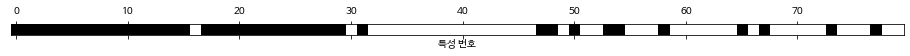

In [7]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=40)
select.fit(X_train, y_train)

mask = select.get_support()

plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel('특성 번호')
plt.yticks([])
plt.show()

In [8]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

rfe = LogisticRegression(max_iter=5000).fit(X_train, y_train)
print(f'전체 특성을 사용한 점수: {rfe.score(X_test, y_test):.3f}')

rfe =LogisticRegression(max_iter=5000).fit(X_train_rfe, y_train)
print(f'선택된 특성을 사용한 점수: {rfe.score(X_test_rfe, y_test):.3f}')

print("RFE에 사용한 모델의 선택된 특성을 사용한 점수: {:.3f}".format(select.score(X_test, y_test)))

전체 특성을 사용한 점수: 0.951
선택된 특성을 사용한 점수: 0.940
RFE에 사용한 모델의 선택된 특성을 사용한 점수: 0.951


# 상식적인 방법

* Citibike 데이터

In [9]:
citibike = mglearn.datasets.load_citibike()
print(citibike.head())

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


Text(0, 0.5, '대여횟수')

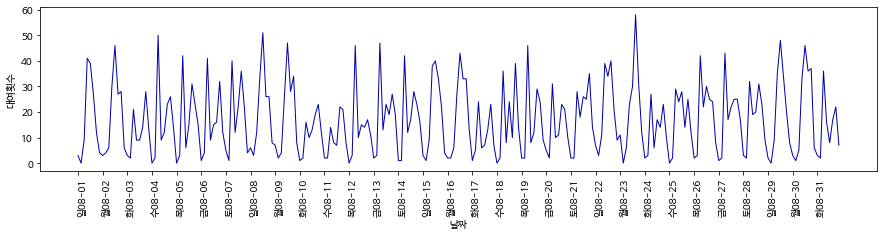

In [10]:
plt.figure(figsize=(15,3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D')
week = ['월', '화', '수', '목', '금', '토', '일']
xticks_name = [week[int(w)]+d for w, d in zip(xticks.strftime('%w'), xticks.strftime( '%m-%d'))]
plt.xticks(xticks, xticks_name, rotation=90, ha='left')
plt.plot(citibike, linewidth=1)
plt.xlabel('날짜')
plt.ylabel('대여횟수')

## 랜덤 포레스트 적용

In [11]:
y = citibike.to_numpy()
X = citibike.index.astype('int64').to_numpy().reshape(-1,1)//10**9

n_train = 184

def eval_on_features(features, target, reggressor):
    
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    
    reggressor.fit(X_train, y_train)
    y_pred = reggressor.predict(X_test)
    y_pred_train = reggressor.predict(X_train)
    print(f'테스트 세트 R^2: {reggressor.score(X_test, y_test):.3f}')
    
    plt.figure(figsize=(18,3))
    
    plt.xticks(range(0, len(X), 8), xticks_name, rotation=90, ha='left')
    
    plt.plot(range(n_train), y_train, label='훈련')
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label='테스트')
    plt.plot(range(n_train), y_pred_train, '--', label='훈련 예측')
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label='테스트 예측')
    
    plt.legend(loc=(1.01,0))
    plt.xlabel('날짜')
    plt.ylabel('대여 횟수')

테스트 세트 R^2: -0.035


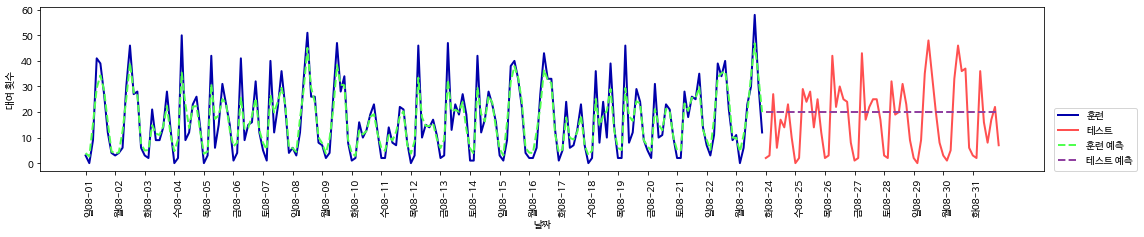

In [12]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)

=> 트리모델은 외삽능력이 없으므로 안좋은 결과

* hour값만 사용

테스트 세트 R^2: 0.600


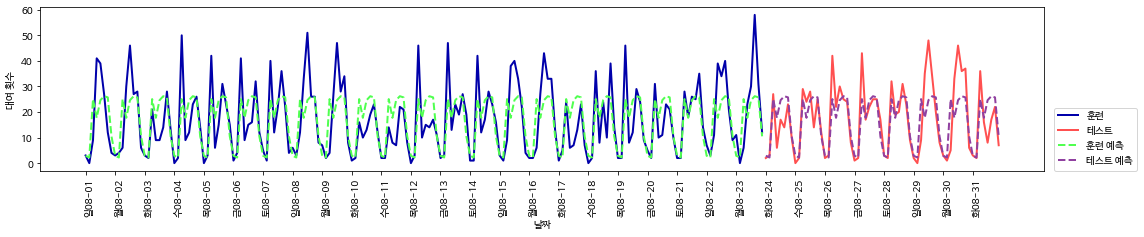

In [13]:
X_hour = citibike.index.hour.to_numpy().reshape(-1,1)
eval_on_features(X_hour, y, regressor)

=> 좋아졌지만 주간 패턴은 예측하지 못하는 것 같으므로 요일 정보 추가

* 요일값 추가

테스트 세트 R^2: 0.842


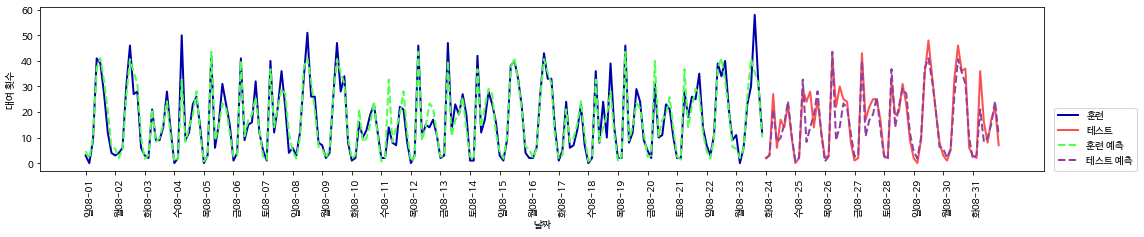

In [14]:
X_hour_week = np.hstack([citibike.index.dayofweek.to_numpy().reshape(-1,1), X_hour])
eval_on_features(X_hour_week, y, regressor)

=> 굿

## Linear model 적용

테스트 세트 R^2: 0.132


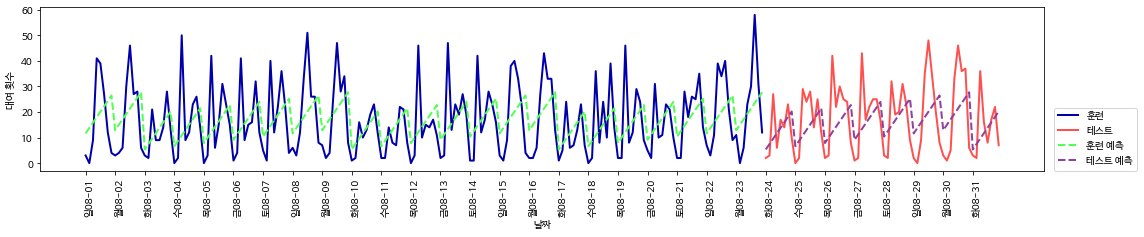

In [15]:
from sklearn.linear_model import LinearRegression, Ridge
eval_on_features(X_hour_week, y, LinearRegression())

=> 요일, 시간 정보가 정수로 인코딩되어 있어서 연속형 변수로 해석되기 때문에 이상한 예측

* 원핫 인코딩

테스트 세트 R^2: 0.619


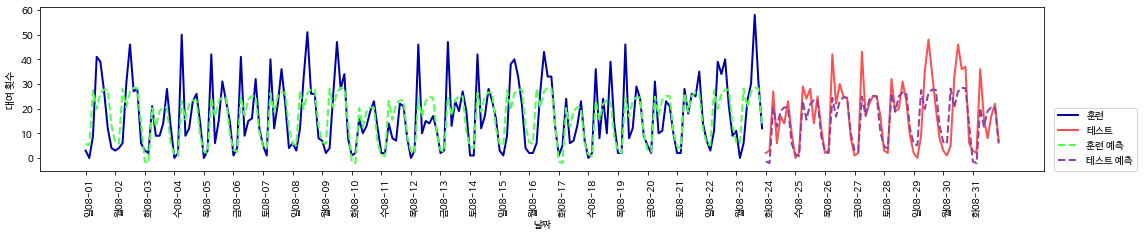

In [16]:
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

eval_on_features(X_hour_week_onehot, y, Ridge())

* 상호작용 특성 적용

테스트 세트 R^2: 0.845


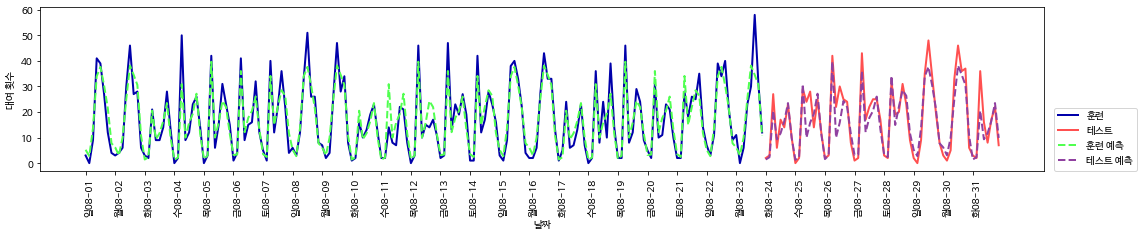

In [17]:
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

=> 굿

* 이 모델의 장점은 계수를 통해 무엇이 학습되었는지 볼 수 있음

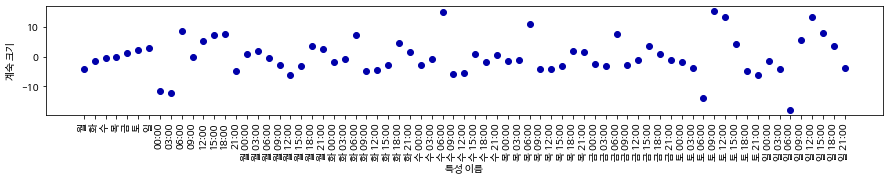

In [18]:
hour = [f'{i:02}:00' for i in range(0,24,3)]
day = ['월', '화', '수', '목', '금', '토', '일']
features = day + hour

features_poly = poly_transformer.get_feature_names(features)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

plt.figure(figsize=(15,2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel('특성 이름')
plt.ylabel('계숙 크기')
plt.show()